## All Lib needed

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from skimage.io import imread
from tomopy.misc.corr import remove_outlier
from tqdm.notebook import trange, tqdm
import algotom.prep.calculation as calc
import svmbir
from tilt import *
import timeit
import dxchange
import bm3d_streak_removal as bm3d
from pathlib import Path

import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display

## Functions used

In [3]:
class file_picker():
    def __init__(self, ipts):
        self.ipts = ipts
        self.list_save = []
        self._drop_temp = None
        
        _optlist = glob.glob(os.path.join("/HFIR/CG1D/IPTS-{}".format(self.ipts), '*'))
        self.drop = widgets.Dropdown(layout={'width': 'initial'}, options = _optlist,
                                     style={'description_width': 'initial'}, description = "path")
        self.path_list = {}
        
        button = widgets.Button(layout={'width': 'initial'}, description="open")
        button.on_click(self.on_button_clicked)
        
        return_button = widgets.Button(layout={'width': 'initial'}, description="return")
        return_button.on_click(self.set_return_button_cliked)
        path_buttons = widgets.HBox([button, return_button])
        
        self.keyword = widgets.Text(placeholder='Type keywords', style={'description_width': 'initial'},
                                    description='String used for searching:')
        
        search_button = widgets.Button(layout={'width': 'initial'}, description="Search")
        search_button.on_click(self.set_search_button_clicked)
        search_box = widgets.HBox([self.keyword, search_button])        
        
        ob_button = widgets.Button(layout={'width': 'initial'}, description="Select as OB")
        ob_button.on_click(self.set_ob_button_clicked)

        df_button = widgets.Button(layout={'width': 'initial'}, description="Select as DF")
        df_button.on_click(self.set_df_button_clicked)
        
        proj_button = widgets.Button(layout={'width': 'initial'}, description="Select as Projection")
        proj_button.on_click(self.set_proj_button_clicked)
        set_buttons = widgets.HBox([ob_button, df_button, proj_button])
        
        ui = widgets.VBox([self.drop, path_buttons, search_box, set_buttons])
        display(ui)
        
    def on_button_clicked(self, b):  
        self._drop_temp = self.drop.value
        _optlist = glob.glob(os.path.join(self.drop.value, '*'))
        self.drop.options = _optlist        
    
    def set_return_button_cliked(self, b):
        if self.drop.value == None:
            _optlist = glob.glob(os.path.join(os.path.dirname(self._drop_temp), '*'))
        else:
            _optlist = glob.glob(os.path.join(os.path.dirname(os.path.dirname(self.drop.value)), '*'))
        self.drop.options = _optlist
        
    def set_search_button_clicked(self, b):
        if self.list_save == []:
            self.list_save = self.drop.value
        
        _optlist = glob.glob(os.path.join(os.path.dirname(self.list_save), 
                                          '*{}*'.format(self.keyword.value)))
        self.drop.options = _optlist
    
    def set_ob_button_clicked(self, b):
        self.path_list["ob"] = self.drop.value
        print("ob data path is: {}".format(self.path_list["ob"]))

    def set_df_button_clicked(self, b):
        self.path_list["df"] = self.drop.value
        print("df data path is: {}".format(self.path_list["df"]))
        
    def set_proj_button_clicked(self, b):
        self.path_list["proj"] = self.drop.value
        print("projection data path is: {}".format(self.path_list["proj"]))

def load_repeat_raw(lst, gamma_diff, ksize, ncore):
    tmp_tif = imread(lst[0])
    row, col = tmp_tif.shape
    num = len(lst)
    stack = np.zeros((row, col, num))
    for i in range(num):
        stack[:,:, i] = imread(lst[i])
    
    if num > 1:
        raw = remove_outlier(np.sum(stack, axis = 2), gamma_diff, size = ksize, 
                             ncore=ncore).astype(np.ushort)
    else:
        raw = remove_outlier(stack, gamma_diff, size = ksize, 
                             ncore=ncore).astype(np.ushort)
    return raw

def get_ang(file_lst):
    ang = []
    for f in file_lst:
        _split = f.split('/')[-1].split('_')
        ang.append(float('.'.join([_split[-3], _split[-2]])))
    return ang

## Set data path

In [4]:
f = file_picker(24959) #26984 #25265

### Print path setting

In [ ]:
path_list = f.path_list
print("path_list[\"ob\"] = \"{}\" ".format(f.path_list["ob"]))
print("path_list[\"df\"] = \"{}\" ".format(f.path_list["df"]))
print("path_list[\"proj\"] = \"{}\" ".format(f.path_list["proj"]))

#### If the path already know

In [5]:
path_list = {}
path_list["ob"] = "/HFIR/CG1D/IPTS-24959/raw/ob/August23_2020" 
path_list["df"] = "/HFIR/CG1D/IPTS-24959/raw/df/August24_2020" 
path_list["proj"] = "/HFIR/CG1D/IPTS-24959/raw/ct_scans/Aug21_2020_restart" 

## Load raw data

### Parameters setting

In [8]:
acquisition_time = 10
gamma_diff = 20
ncore = 64
base_path = "/netdisk/imaging/data_hfir/for_shimin/rat_femur" # path to save processed data
sample_name = "Aug21_2020_restart"

### Load OB

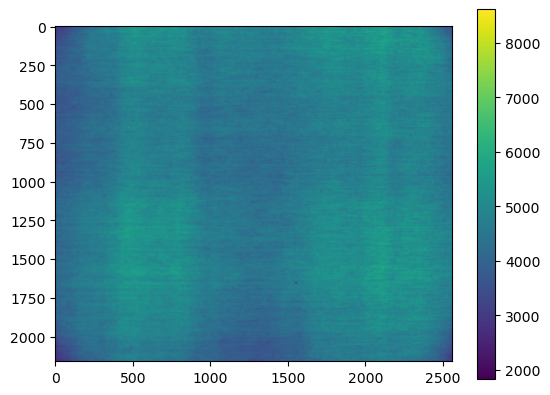

In [7]:
ob_lst = glob.glob(os.path.join(path_list["ob"], "*OB_{:0>4}*.tif*".format(acquisition_time)))
ob_lst.sort()

repeat_num = 4
ksize = 10
OB = [load_repeat_raw(ob_lst[i:i+repeat_num], gamma_diff, ksize, ncore) for i in np.arange(0, len(ob_lst), repeat_num)]
ob = sum(OB)/len(OB)
plt.imshow(ob); plt.colorbar()

#### Check if smoothed too much

In [ ]:
lst = ob_lst[:4]

tmp_tif = imread(lst[0])
row, col = tmp_tif.shape
num = len(lst)
stack = np.zeros((row, col, num))
for i in range(num):
    stack[:,:, i] = imread(lst[i])

combined = remove_outlier(np.sum(stack, axis = 2), gamma_diff, size = ksize, 
                             ncore=ncore).astype(np.ushort)

ratio = combined/np.sum(stack, axis = 2)
plt.plot(np.mean(ratio, axis = 0))
plt.title("Ratio values processed/raw")

#### Save processed OB

In [74]:
ob_save_path = os.path.join(base_path, sample_name,'ob')
Path(ob_save_path).mkdir(parents=True, exist_ok=True)
dxchange.writer.write_tiff(ob, fname=os.path.join(ob_save_path, '_'.join(os.path.split(ob_lst[0])[-1].split('_')[:-1]+['4sum'])),
                           overwrite=True)

### Load DF

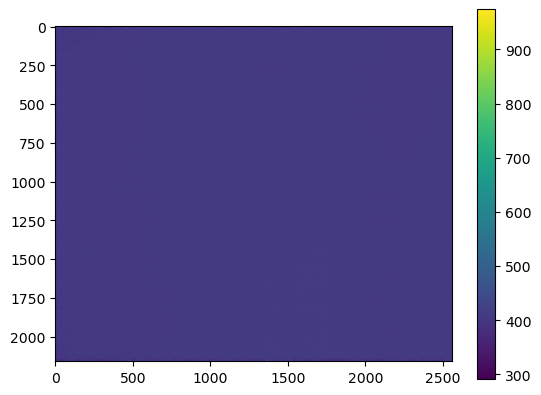

In [89]:
df_lst = glob.glob(os.path.join(path_list["df"], "*DF_{:0>4}*.tif*".format(acquisition_time)))
df_lst.sort()

repeat_num = 4
DF = [load_repeat_raw(df_lst[i:i+repeat_num], gamma_diff, ksize, ncore) for i in np.arange(0, len(df_lst), repeat_num)]
df = sum(DF)/len(DF)
plt.imshow(df); plt.colorbar()

#### Save processed DF

In [90]:
df_save_path = os.path.join(base_path, sample_name,'df')
Path(df_save_path).mkdir(parents=True, exist_ok=True)
dxchange.writer.write_tiff(df, fname=os.path.join(df_save_path, '_'.join(os.path.split(df_lst[0])[-1].split('_')[:-1]+['4sum'])),
                           overwrite=True)

### Load projections

In [15]:
proj_lst = glob.glob(os.path.join(path_list["proj"], "*.tif*"))
proj_lst_sorted = sorted(proj_lst, key=lambda s: os.path.split(s)[-1][-17:])

#### Export angle list

In [16]:
ang_lst_raw = get_ang(proj_lst_sorted)
ang_lst = list(dict.fromkeys(ang_lst_raw))

#### Save angle list

In [ ]:
np.save(os.path.join(base_path, sample_name, "angles.npy"), ang_lst)

#### Load raw projections and combine together if needed

##### Test kenel size for gamma removal

In [ ]:
ksize = 15 
ang = ang_lst[754]
print('Projection @ {}˚'.format(ang))
num1, num2 =str(ang).split('.')
_proj_lst_tmp = glob.glob(os.path.join(path_list["proj"], "*_{:0>3}_{:0<3}_*".format(num1,num2)))
lst = _proj_lst_tmp

tmp_tif = imread(lst[0])
row, col = tmp_tif.shape
num = len(lst)
stack = np.zeros((row, col, num))
for i in range(num):
    stack[:,:, i] = imread(lst[i])

combined = remove_outlier(np.sum(stack, axis = 2), gamma_diff, size = ksize, 
                             ncore=ncore).astype(np.ushort)

ratio = combined/np.sum(stack, axis = 2)
plt.plot(np.mean(ratio, axis = 0))
plt.title("Ratio values processed/raw")


In [43]:
proj_save_path = os.path.join(base_path, sample_name, 'proj_4sum')
Path(proj_save_path).mkdir(parents=True, exist_ok=True)

for ang in tqdm(ang_lst[:]):
    num1, num2 =str(ang).split('.')
    _proj_lst_tmp = glob.glob(os.path.join(path_list["proj"], "*_{:0>3}_{:0<3}_*".format(num1,num2)))
    _proj = load_repeat_raw(_proj_lst_tmp, gamma_diff, 15, ncore)
    dxchange.writer.write_tiff(_proj, fname=os.path.join(proj_save_path, '_'.join(os.path.split(_proj_lst_tmp[0])[-1].split('_')[:-1])),
                               overwrite=True)

  0%|          | 0/3195 [00:00<?, ?it/s]

## Normalization

In [11]:
proj_save_path = os.path.join(base_path, sample_name, 'proj_4sum')
processed_proj_lst = os.listdir(proj_save_path)
processed_proj_lst.sort()

norm_save_path = os.path.join(base_path, sample_name, 'norm_4sum')
Path(norm_save_path).mkdir(parents=True, exist_ok=True)

In [12]:
#If start from here
ob = imread(glob.glob(os.path.join(base_path, sample_name, 'ob', '*.tiff'))[0])
df = imread(glob.glob(os.path.join(base_path, sample_name, 'df', '*.tiff'))[0])

In [137]:
for idx, f in tqdm(zip(range(len(processed_proj_lst[:])), processed_proj_lst[:])):
    _proj = imread(os.path.join(proj_save_path, f))
    _norm_data = -np.log((_proj-df)/(ob-df))
    _norm_data = np.nan_to_num(_norm_data, nan=0, posinf=0, neginf=0)  
    #dxchange.writer.write_tiff(_norm_data, fname=os.path.join(norm_save_path, 'norm_'+f), overwrite=True)

0it [00:00, ?it/s]/tmp/ipykernel_2516070/2026733465.py:3: RuntimeWarning: invalid value encountered in log
  _norm_data = -np.log((_proj-df)/(ob-df))
1it [00:00,  7.52it/s]


### Load normalized data

In [44]:
norm_lst = os.listdir(os.path.join(base_path, sample_name, 'norm_4sum'))
norm_lst.sort()

ang_lst = np.load(os.path.join(base_path, sample_name, "angles.npy"))
idx_180 = np.argmin(abs(ang_lst-180))   # find the angle index of 180˚
angles = ang_lst[:idx_180+1] # 0-180˚

row, col = imread(os.path.join(norm_save_path, norm_lst[0])).shape
norm = np.zeros((len(angles), row, col))
for idx in trange(len(angles)):
    norm[idx] = imread(os.path.join(norm_save_path, norm_lst[idx]))

  0%|          | 0/1594 [00:00<?, ?it/s]

## Crop data

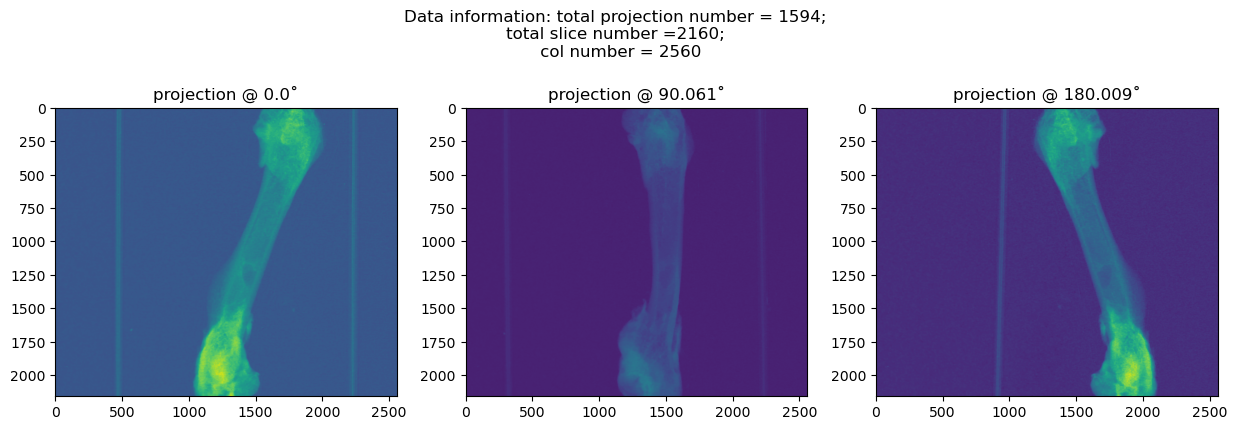

In [101]:
# display sample projections
display_proj_idx = [0, int(len(angles)/2), -1]
fig, axes = plt.subplots(1, len(display_proj_idx), figsize = (15,5))
fig.suptitle('Data information: total projection number = {}; \ntotal slice number ={}; \n col number = {}'.format(norm.shape[0], norm.shape[1], norm.shape[2]))
for i in range(len(display_proj_idx)):
    axes[i].imshow(norm[display_proj_idx[i]])
    axes[i].set_title('projection @ {}˚'.format(angles[display_proj_idx[i]]))


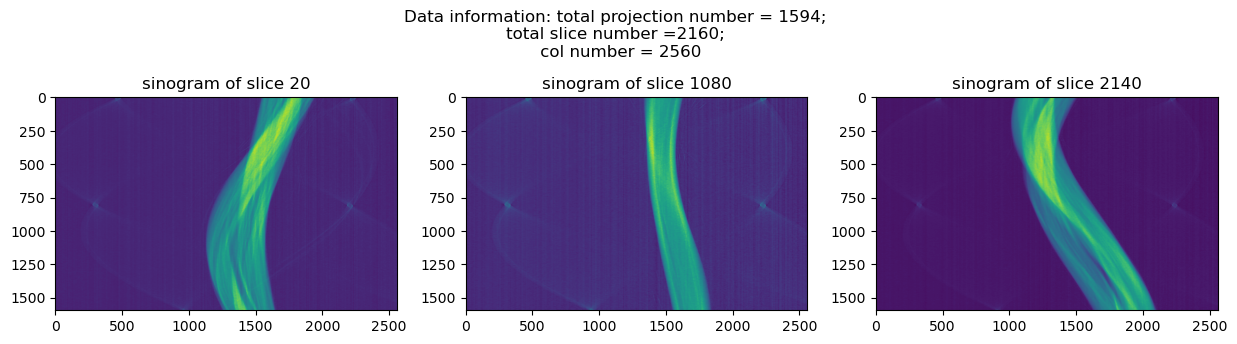

In [83]:
# display sample sinogram
display_slice_idx = [20, int(norm.shape[1]/2), int(norm.shape[1])-20]
fig, axes = plt.subplots(1, len(display_slice_idx), figsize = (15,4))
fig.suptitle('Data information: total projection number = {}; \ntotal slice number ={}; \n col number = {}'.format(norm.shape[0], norm.shape[1], norm.shape[2]))
for i in range(len(display_slice_idx)):
    axes[i].imshow(norm[:,display_slice_idx[i]])
    axes[i].set_title('sinogram of slice {}'.format(display_slice_idx[i]))

### Crop

In [109]:
left, right = 950, 2150
z_start, z_end = 20, -20
norm_crop = norm[:, z_start:z_end, left:right]

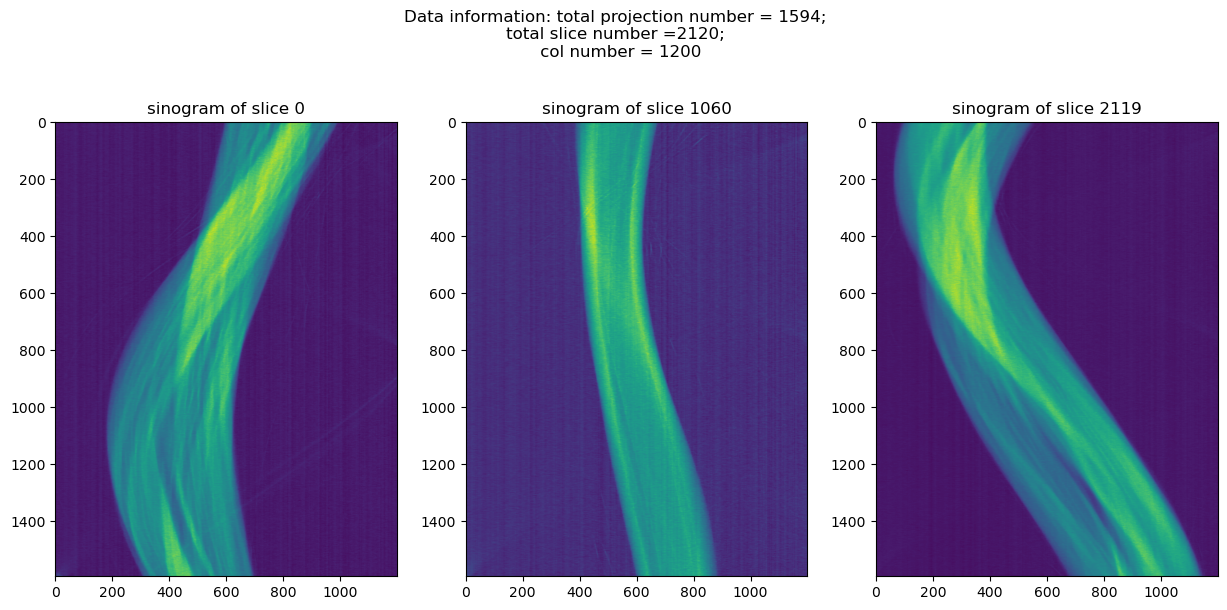

In [111]:
# display sample cropped sinogram
display_slice_idx = [0, int(norm_crop.shape[1]/2), int(norm_crop.shape[1]-1)]
fig, axes = plt.subplots(1, len(display_slice_idx), figsize = (15,7))
fig.suptitle('Data information: total projection number = {}; \ntotal slice number ={}; \n col number = {}'.format(norm_crop.shape[0], norm_crop.shape[1], norm_crop.shape[2]))
for i in range(len(display_slice_idx)):
    axes[i].imshow(norm_crop[:,display_slice_idx[i]])
    axes[i].set_title('sinogram of slice {}'.format(display_slice_idx[i]))

## Tilt removal

### Find tilt angle

In [112]:
print("Finding the tilt angle...")
tilt_ang = calculate_tilt(image0=norm_crop[0], image180=norm_crop[1593,])
print("Found the tilt angle: ", tilt_ang.x)

Finding the tilt angle...
Found the tilt angle:  -0.5557724178001451


### Remove tilt

In [113]:
norm_rm_tilt = apply_tilt_correction(norm_crop, tilt_ang.x, rot_center= None, ncore=64)

/home/gxt/Projects/CT_reconstruction/tilt.py:117: TqdmWarning: Iterable length 1594 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  rst = process_map(


Applying tilt corr:   0%|          | 0/1594 [00:00<?, ?it/s]

In [114]:
# save norm array in case 
np.save(os.path.join(base_path, sample_name, "norm_180_notilt_4sum.npy"), norm_rm_tilt)

## Ring artifact removal

In [116]:
_t0 = timeit.default_timer()
_norm_bm3d = bm3d.extreme_streak_attenuation(norm_rm_tilt)
x_rm = bm3d.multiscale_streak_removal(_norm_bm3d)
_t1 = timeit.default_timer()
print("costed {} s".format((_t1-_t0)))

Median filtering, iteration 0


### bm3d is slow, then run job background

## Reconstruction via svMBIR

In [1]:
def load_sino_stack(z_start, z_numSlice, sino_lst, norm_path):
    sino_temp = np.load(os.path.join(norm_path, sino_lst[0]))
    num_ang, _, num_cols = sino_temp.shape
    sino = np.zeros((num_ang, z_numSlice, num_cols))
    for i in range(z_start, z_start + z_numSlice):
        sino[:, i-z_start] = np.load(os.path.join(norm_path, sino_lst[i]))[:,0]
    return sino

In [13]:
sharpness = 0.0
snr_db = 40
base_path = "/netdisk/imaging/data_hfir/for_shimin/rat_femur/Aug21_2020_restart"
ang_lst = np.load(os.path.join(base_path,"angles.npy"))

idx_180 = np.argmin(abs(ang_lst-180))   # find the angle index of 180˚
angles = ang_lst[:idx_180+1] # 0-180˚
angles_rad = np.pi - np.deg2rad(angles)

norm_path = os.path.join(base_path, 'norm_final_4sum')
sino_lst = os.listdir(norm_path)
sino_lst.sort()

In [20]:
z_numSlice = 40
offset = int(sino_lst[0].split('.')[0].split('_')[-1]) # some slice might be cropped
file_prefix = '_'.join(sino_lst[0].split('_')[1:-1])
recon_path = os.path.join(base_path, "recon")

In [ ]:
for z_start in np.arange(0, len(sino_lst), z_numSlice-10):
    if z_start + z_numSlice >= len(sino_lst):
        sino = load_sino_stack(z_start, len(sino_lst)-z_start, sino_lst, norm_path)
        bd0, bd1 = 5, z_numSlice
    else:
        sino = load_sino_stack(z_start, z_numSlice, sino_lst, norm_path)
        bd0 = 0 if z_start ==0 else 5
        bd1 = -5

    _sino = np.moveaxis(sino, 1, 0)
    rot_center = calc.find_center_vo(_sino[int(z_numSlice/2-1),])
    print('Estimated center of rotation:{}'.format(rot_center) )
    _, _, num_cols = sino.shape
    center_offset = rot_center-num_cols/2

    x_hat = svmbir.recon(sino, angles_rad,
                         num_rows = num_cols, num_cols = num_cols, center_offset=center_offset, 
                         sharpness=sharpness,  verbose = 0, positivity = False, num_threads = 128,
                         svmbir_lib_path = '/netdisk/imaging/data_hfir/for_shimin/', 
                         max_resolutions=4)

    dxchange.writer.write_tiff_stack(x_hat[bd0:bd1,], 
                                        fname=os.path.join(recon_path, file_prefix),
                                        start=z_start+offset+bd0, overwrite=True)